# Signal to noise calculations for the Australian Space Eye proposal

This notebook contains signal to noise calculations for the Australian Space Eye CubeSat space telescope proposal. The signal to noise/sensitivity are estimated for the main science aims of the mission, specifically absolute photometry of the Cosmic Infrared Background (CIB) and Zodiacal Light (ZL), and low surface brightness imaging of low redshift galaxies.

Two filter sets are considered:

1. 2 sets of 3 variant i and z band filters, designed to create 'virtual narrowband filters' in the Calcium triplet region in order to separate the CIB and ZL components.
1. 2 broadband i and z filters and 2 narrowband Calcium triplet 'on' and 'off' filters.

In each case each filter receives an equal share of the observing time.

## Standard imports

In [1]:
import sys
sys.path.append('..')

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import astropy.units as u
from astropy.table import Table
from scipy.optimize import least_squares

In [4]:
# Minimal, uncluttered notebook display of astropy Tables
def show_no_dtype(astropy_table):
    return HTML('\n'.join(astropy_table.pformat(html=True,
                                                show_dtype=False,
                                                tableclass="table-condensed table-bordered")))

## Import gunagala

`gungala` is the library that performs the SNR/sensitivity/ETC calculations. The main submodule is `imager` which includes the `Imager` class which represents an astronomical imaging instrument.

In [5]:
from gunagala import imager

/home/ajh/miniconda3/envs/gunagala/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Create imagers

The `gunagala.imager.create_imagers()` creates a dictionary of `Imager` objects based on the `gunagala/data/performance.yaml` configuration file as well as performance data files in `gunagala/data/performance_data`. The instrument configuration/specifications should be set by editing these files.

Currently the file describes 3 variants of the Australian Space Eye concept and, for comparison, a 5 lens version of the Huntsman Telephoto Array.

In [6]:
imagers = imager.create_imagers()

huntsman = imagers['canon_sbig']  # A 5 lens array

ase_2016 = imagers['ase_2016']  # 6U with 1x 90 mm telescope & overlapping broadband filters
ase_2017 = imagers['ase_2017']  # 6U with 1x 90 mm telescope & broad and narrowband filters

waves_h = huntsman.wavelengths
waves_a = ase_2016.wavelengths

## Inspect imager properties

Many properties of the imagers can be accessed as properties of the `Imager` object.

### Filter profiles 

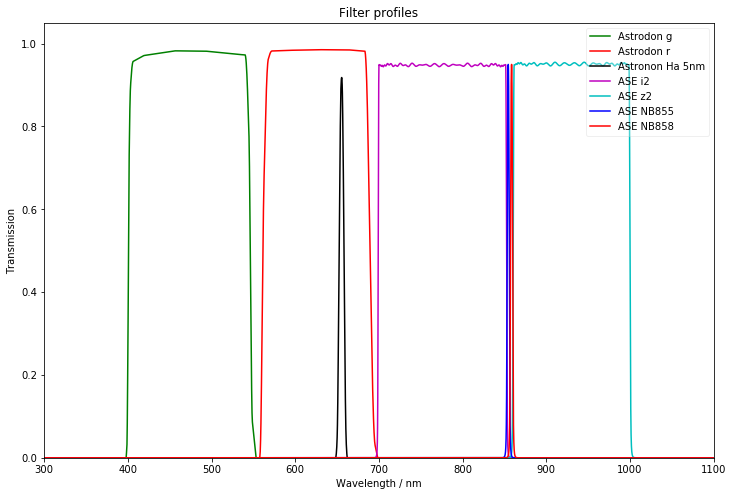

In [7]:
plt.plot(waves_h, huntsman.filters['g'].transmission(waves_h), 'g-', label='Astrodon g')
plt.plot(waves_h, huntsman.filters['r'].transmission(waves_h), 'r-', label='Astrodon r')
plt.plot(waves_h, huntsman.filters['Ha_5nm'].transmission(waves_h), 'k-', label='Astronon Ha 5nm')
#plt.plot(waves_h, huntsman.filters['Ha_3nm'].transmission(waves_h), 'k-', label='Astronon Ha 3nm')


plt.plot(waves_a, ase_2017.filters['ase_i1'].transmission(waves_a), 'm-', label='ASE i2')
plt.plot(waves_a, ase_2017.filters['ase_z3'].transmission(waves_a), 'c-', label='ASE z2')
plt.plot(waves_a, ase_2017.filters['ase_nb855'].transmission(waves_a), 'b-', label='ASE NB855')
plt.plot(waves_a, ase_2017.filters['ase_nb858'].transmission(waves_a), 'r-', label='ASE NB858')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlabel('Wavelength / nm')
plt.ylabel('Transmission')
plt.title('Filter profiles')
plt.xlim(300, 1100)
plt.ylim(0, 1.05)
plt.gcf().set_size_inches(12,8)

In [8]:
ase_2017.filters['ase_nb855'].FWHM

<Quantity 2.658233245264455 nm>

In [9]:
ase_2017.filters['ase_nb855'].lambda_c

<Quantity 854.3935690666981 nm>

In [10]:
ase_2017.filters['ase_nb858'].FWHM

<Quantity 2.666089320008723 nm>

In [11]:
ase_2017.filters['ase_nb858'].lambda_c

<Quantity 858.3907297645989 nm>

### Image sensor quantum efficiency

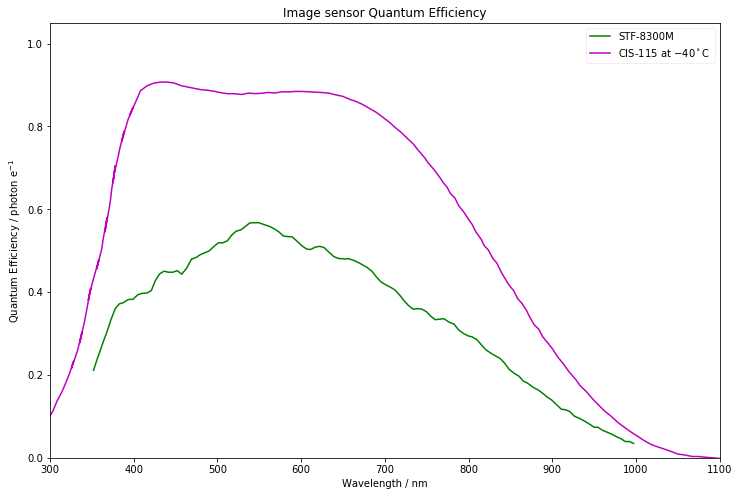

In [12]:
plt.plot(huntsman.camera.wavelengths, huntsman.camera.QE, 'g-', label='STF-8300M')
plt.plot(ase_2017.camera.wavelengths, ase_2017.camera.QE, 'm-', label='CIS-115 at $-40^\circ$C')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlabel('Wavelength / nm')
plt.ylabel('Quantum Efficiency / photon e$^{-1}$')
plt.title('Image sensor Quantum Efficiency')
plt.xlim(300, 1100)
plt.ylim(0,1.05)
plt.gcf().set_size_inches(12,8)

### End to end efficiency

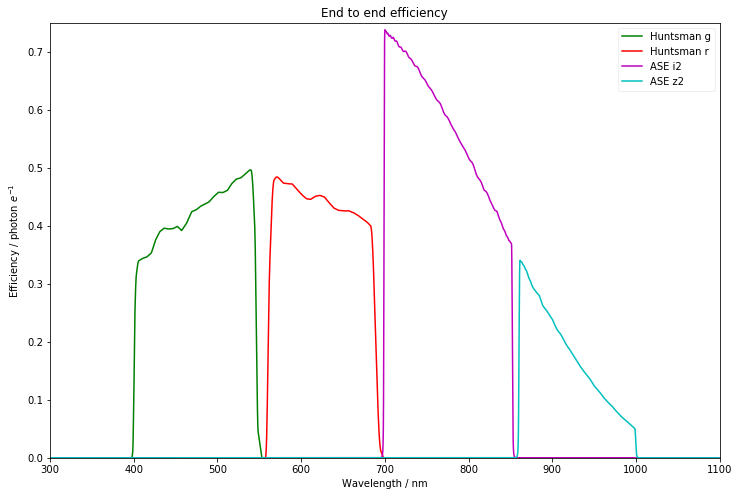

In [13]:
plt.plot(waves_h, huntsman.efficiencies['g'], 'g-', label='Huntsman g')
plt.plot(waves_h, huntsman.efficiencies['r'], 'r-', label='Huntsman r')

plt.plot(waves_a, ase_2017.efficiencies['ase_i1'], 'm-', label='ASE i2')
plt.plot(waves_a, ase_2017.efficiencies['ase_z3'], 'c-', label='ASE z2')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlabel('Wavelength / nm')
plt.ylabel('Efficiency / photon $e^{-1}$')
plt.title('End to end efficiency')
plt.xlim(300, 1100)
plt.ylim(0, 0.75)
plt.gcf().set_size_inches(12,8)

### Sky background model

For ASE the sky background is expected to dominated by the Zodiacal Light. For this we are use a scaled, reddened Solar spectrum following the prescription used by the HST ETC.

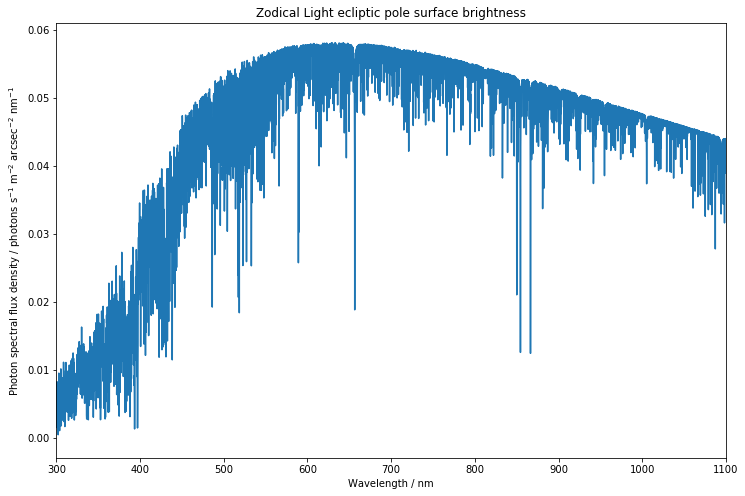

In [14]:
plt.plot(ase_2017.sky.waves.to(u.nm), 
         ase_2017.sky.photon_sfd.to(u.photon * u.s**-1 * u.m**-2 * u.arcsecond**-2 * u.nm**-1))
plt.xlim(300, 1100)
plt.title('Zodical Light ecliptic pole surface brightness')
plt.xlabel('Wavelength / nm')
plt.ylabel('Photon spectral flux density / photons s$^{-1}$ m$^{-2}$ arcsec$^{-2}$ nm$^{-1}$')
plt.gcf().set_size_inches(12, 8)

### Filter transmission profile details


#### Virtual narrowband filter set

Close up of the blue edge of the 3 z band filter variants, shown together with the Zodiacal Light spectrum and its Calcium triplet absorption lines.

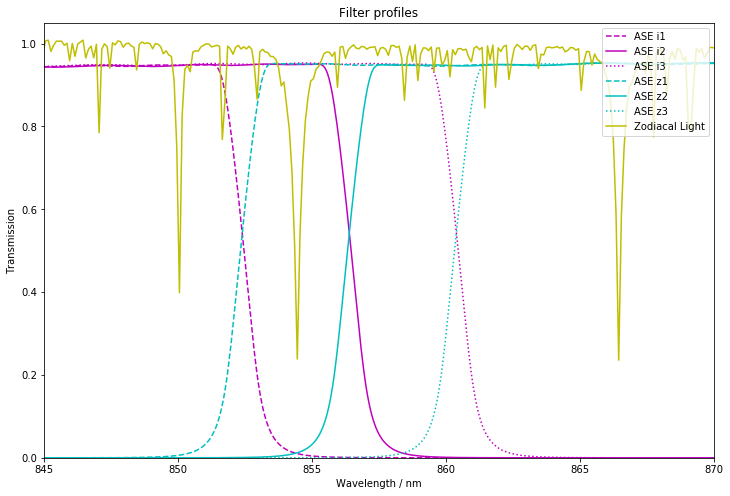

In [15]:
plt.plot(waves_a, ase_2016.filters['ase_i1'].transmission(waves_a), 'm--', label='ASE i1')
plt.plot(waves_a, ase_2016.filters['ase_i2'].transmission(waves_a), 'm-', label='ASE i2')
plt.plot(waves_a, ase_2016.filters['ase_i3'].transmission(waves_a), 'm:', label='ASE i3')

plt.plot(waves_a, ase_2016.filters['ase_z1'].transmission(waves_a), 'c--', label='ASE z1')
plt.plot(waves_a, ase_2016.filters['ase_z2'].transmission(waves_a), 'c-', label='ASE z2')
plt.plot(waves_a, ase_2016.filters['ase_z3'].transmission(waves_a), 'c:', label='ASE z3')

plt.plot(ase_2017.sky.waves.to(u.nm), 1.1 *ase_2017.sky.photon_sfd/ase_2017.sky.photon_sfd.max(), 'y-', label='Zodiacal Light')

plt.legend(loc='upper right', fancybox=True, framealpha=0.8)
plt.xlabel('Wavelength / nm')
plt.ylabel('Transmission')
plt.title('Filter profiles')
plt.xlim(845, 870)
plt.ylim(0, 1.05)
plt.gcf().set_size_inches(12,8)

The 'virtual narrowband filters' that result from the pair-wise differences between the 3 z band filters coincide with the strongest Ca-triplet absorption line and adjacent continuum.  Meaurements of the sky background in these 3 filters therefore allow a measurement of the depth of the Ca-triplet absorption.



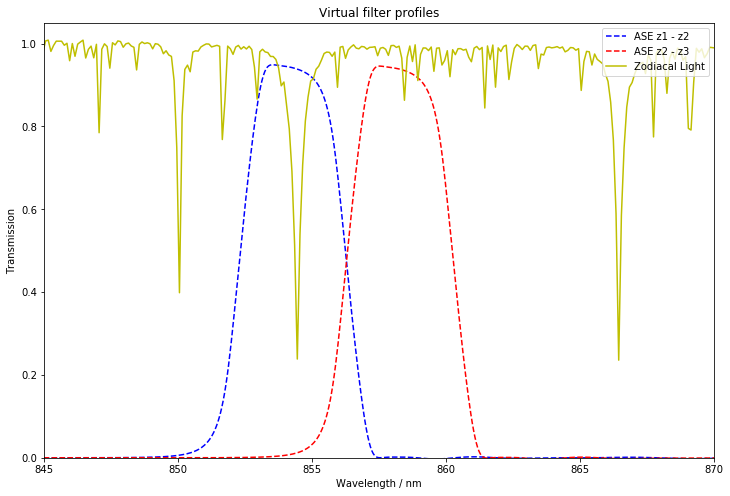

In [16]:
plt.plot(waves_a, 
         ase_2016.filters['ase_z1'].transmission(waves_a) - ase_2016.filters['ase_z2'].transmission(waves_a),
         'b--', label='ASE z1 - z2')
plt.plot(waves_a,
         ase_2016.filters['ase_z2'].transmission(waves_a) - ase_2016.filters['ase_z3'].transmission(waves_a),
         'r--', label='ASE z2 - z3')

plt.plot(ase_2017.sky.waves.to(u.nm), 1.1 * ase_2017.sky.photon_sfd/ase_2017.sky.photon_sfd.max(), 
         'y-', label='Zodiacal Light')

plt.legend(loc='upper right', fancybox=True, framealpha=0.8)
plt.xlabel('Wavelength / nm')
plt.ylabel('Transmission')
plt.title('Virtual filter profiles')
plt.xlim(845, 870)
plt.ylim(0, 1.05)
plt.gcf().set_size_inches(12,8)

#### Standard filter set

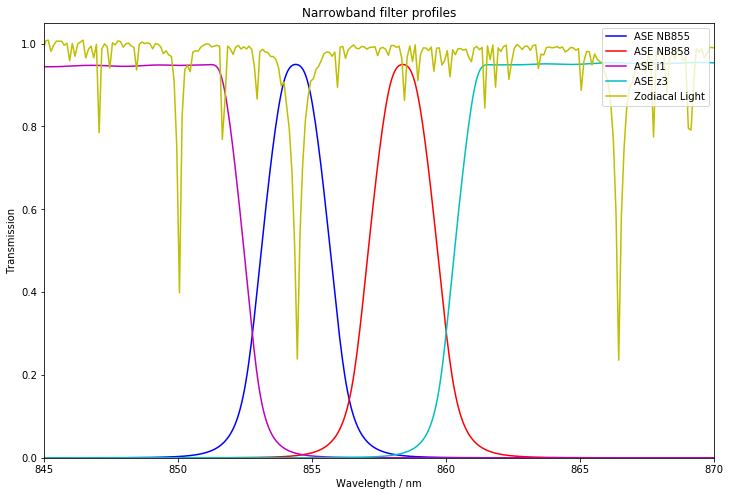

In [17]:
plt.plot(waves_a, ase_2017.filters['ase_nb855'].transmission(waves_a), 'b-', label='ASE NB855')
plt.plot(waves_a, ase_2017.filters['ase_nb858'].transmission(waves_a), 'r', label='ASE NB858')

plt.plot(waves_a, ase_2016.filters['ase_i1'].transmission(waves_a), 'm-', label='ASE i1')
plt.plot(waves_a, ase_2016.filters['ase_z3'].transmission(waves_a), 'c-', label='ASE z3')

plt.plot(ase_2017.sky.waves.to(u.nm), 1.1 * ase_2017.sky.photon_sfd/ase_2017.sky.photon_sfd.max(), 
         'y-', label='Zodiacal Light')

plt.legend(loc='upper right', fancybox=True, framealpha=0.8)
plt.xlabel('Wavelength / nm')
plt.ylabel('Transmission')
plt.title('Narrowband filter profiles')
plt.xlim(845, 870)
plt.ylim(0, 1.05)
plt.gcf().set_size_inches(12,8)

### Detected sky background levels

Pre-calculated for each filter. Also dark current for comparison.

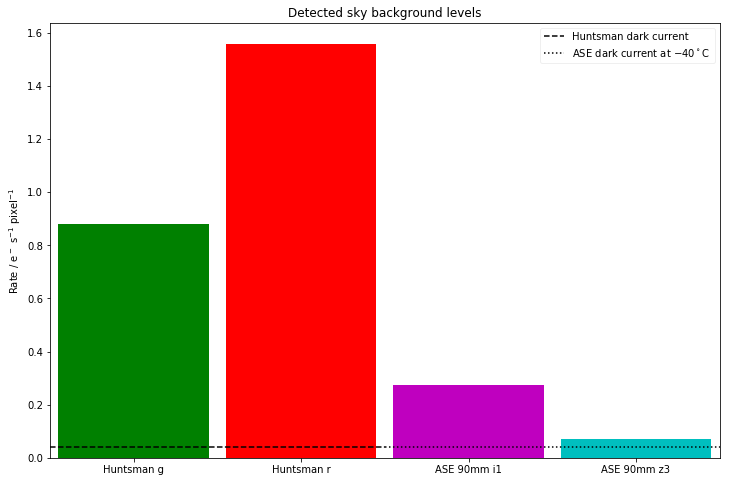

In [18]:
plt.bar((1, 2), (huntsman.sky_rate['g'].value, huntsman.sky_rate['r'].value),
        width=0.9, align='center', color=('g', 'r'))
plt.hlines(huntsman.camera.dark_current.value, 0.5, 2.5, linestyle='dashed', label='Huntsman dark current')

plt.bar((3, 4), (ase_2017.sky_rate['ase_i1'].value,
                       ase_2017.sky_rate['ase_z3'].value),
        width=0.9, align='center', color=('m', 'c'))
plt.hlines(ase_2017.camera.dark_current.value, 2.5, 6.5, linestyle='dotted', label='ASE dark current at $-40^\circ$C')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)


plt.xticks((1, 2, 3, 4), 
           ('Huntsman g', 'Huntsman r', 'ASE 90mm i1', 'ASE 90mm z3'))
plt.xlim(0.5,4.5)
plt.ylabel('Rate / e$^-$ s$^{-1}$ pixel$^{-1}$')
plt.title('Detected sky background levels')
plt.gcf().set_size_inches(12, 8)

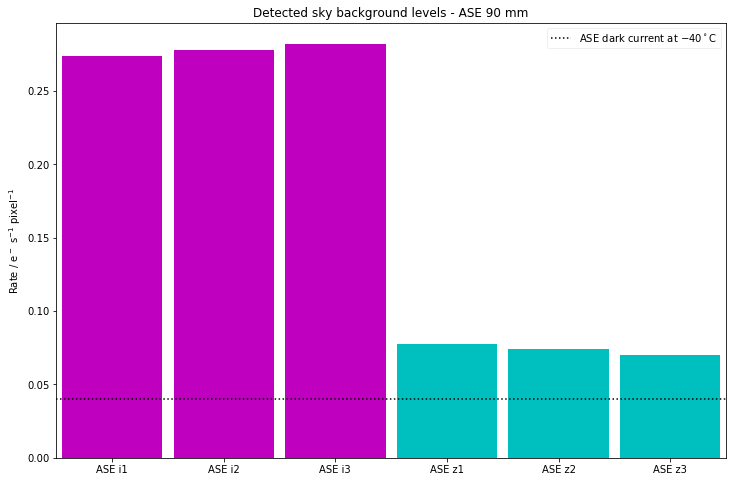

In [19]:
plt.bar((1, 2, 3, 4, 5, 6),
        (ase_2016.sky_rate['ase_i1'].value,
         ase_2016.sky_rate['ase_i2'].value,
         ase_2016.sky_rate['ase_i3'].value,
         ase_2016.sky_rate['ase_z1'].value,
         ase_2016.sky_rate['ase_z2'].value,
         ase_2016.sky_rate['ase_z3'].value),
        width=0.9, align='center', color=('m', 'm', 'm', 'c', 'c', 'c'))
plt.hlines(ase_2016.camera.dark_current.value, 0.5, 6.5, linestyle='dotted', label='ASE dark current at $-40^\circ$C')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlim(0.5,6.5)
plt.xticks((1, 2, 3, 4, 5, 6), ('ASE i1', 'ASE i2', 'ASE i3', 'ASE z1', 'ASE z2', 'ASE z3'))
plt.ylabel('Rate / e$^-$ s$^{-1}$ pixel$^{-1}$')
plt.title('Detected sky background levels - ASE 90 mm')

plt.gcf().set_size_inches(12, 8)

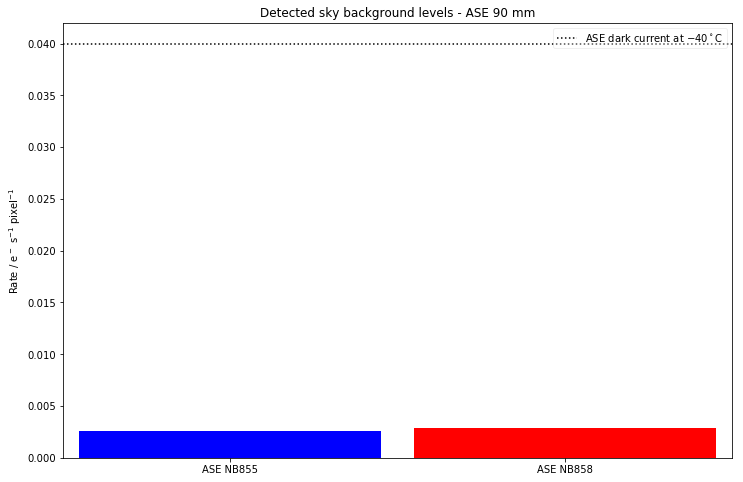

In [20]:
plt.bar((1, 2),
         (ase_2017.sky_rate['ase_nb855'].value,
          ase_2017.sky_rate['ase_nb858'].value),
          width=0.9, align='center', color=('b', 'r', 'b', 'r'))

plt.hlines(ase_2016.camera.dark_current.value, 0.5, 6.5, linestyle='dotted', label='ASE dark current at $-40^\circ$C')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlim(0.5,2.5)
plt.xticks((1, 2), ('ASE NB855', 'ASE NB858'))
plt.ylabel('Rate / e$^-$ s$^{-1}$ pixel$^{-1}$')
plt.title('Detected sky background levels - ASE 90 mm')

plt.gcf().set_size_inches(12, 8)

## Broadband imaging sensitivity

For broadband i and z band imaging we combine the data from all the i band and all the z band filters together.

We expect to observe for approximately 40 minutes of each 100 minute orbit.  Individual sub exposures that therefore be up to 40 minutes long, cosmic rays permitting.

Nominal mission duration is 2 years, allowing up to several months on each target field.

In [21]:
duty_cycle = 40 / 100

### Basic extended source sensitivity, 1 month

Limiting surface brightness in AB magnitudes per square arcsecond given a signal to noise ratio threshold of 1.0 per arcsecond squared and 1 month on target.

#### Virtual narrowband filter set

Here we can consider the 3 variant i and 3 variant z filters to be essentially the same and sum them together. The effective fraction of total exposure time for either or i or z band is then 1/2.

In [22]:
filter_fraction = 3 / 6

iasv = ase_2016.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_i2',
                                      snr_target=1.0,
                                      calc_type='per arcsecond squared')

zasv = ase_2016.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_z2',
                                      snr_target=1.0,
                                      calc_type='per arcsecond squared')

#### Standard broadband filters

Here we have i, z, and 2 narrowband filters. Assuming each are given equal exposure time then each broadband filter gets 1/4 of the total exposure time.

In [23]:
filter_fraction = 1 / 4

iasb = ase_2017.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_i1',
                                      snr_target=1.0,
                                      calc_type='per arcsecond squared')

zasb = ase_2017.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_z3',
                                      snr_target=1.0,
                                      calc_type='per arcsecond squared')

#### Results

In [24]:
t1 = Table(data = (('Virtual narrowband', 'Standard broadband'),
                   u.Quantity((iasv, iasb)).round(decimals=2),
                   u.Quantity((zasv, zasb)).round(decimals=2)),
           names=('Filter set', 'i band', 'z band'))
show_no_dtype(t1)

Filter set,i band,z band
,mag(AB),mag(AB)
Virtual narrowband,27.97,26.98
Standard broadband,27.58,26.56


### Extended source sensitivity, 1 months with binning

Our highest priority science targets will be very extended, allowing significant spatial binning after removal of compact source contaminants. For these a signal to noise threshold of, say, 1.0 per square _arcminute_ may be more appropriate than square arcsecond.  This is equivalent to an SNR of 1/60 per square arcsecond.

#### Virtual narrowband filter set

In [25]:
filter_fraction = 3 / 6

iamv = ase_2016.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_i2',
                                      snr_target=1.0 / 60,
                                      calc_type='per arcsecond squared')

zamv = ase_2016.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_z2',
                                      snr_target=1.0 / 60,
                                      calc_type='per arcsecond squared')

#### Standard broadband filters

In [26]:
filter_fraction = 1 / 4

iamb = ase_2017.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_i1',
                                      snr_target=1.0 / 60,
                                      calc_type='per arcsecond squared')

zamb = ase_2017.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_z3',
                                      snr_target=1.0 / 60,
                                      calc_type='per arcsecond squared')

#### Results

In [27]:
t2 = Table(data = (('Virtual narrowband', 'Standard broadband'),
                   u.Quantity((iamv, iamb)).round(decimals=2),
                   u.Quantity((zamv, zamb)).round(decimals=2)),
           names=('Filter set', 'i band', 'z band'))
show_no_dtype(t2)

Filter set,i band,z band
,mag(AB),mag(AB)
Virtual narrowband,32.42,31.43
Standard broadband,32.03,31.01


## Cosmic Infrared Background & Zodiacal Light measurements

The Cosmic Infrared Background (CIB) and Zodiacal Light (ZL) are both components of the sky background, with ZL being the dominant one. ASE aims to measure the absolute surface brightness of both using multiband photometry, taking advantage of the Calcium triplet absorption features in the ZL spectrum.  The Zodical Light is expected to have equal Ca-triplet depth to the Solar spectrum while the extragalactic background light will not exhibit any absorption lines. Consequently a measurement of the sky background Ca-triplet absorption depth allows the separation of Zodical Light and extragalactic components.

In practice the measurement of the CIB and ZL will be acheived by fitting models to the multiband photometry from ASE. In order to estimate the signal to noise in the fitted parameters we will use a highly simplified model and fitting procedure.



Lower limits on integrated galactic light (EGL) from Driver et al 2017. There are expressed in terms of total flux for each band, need to use approximate filter bandwidths to convert these to a (band averaged) spectral flux density, convert to photon based units and interpolate across all the Space Eye filters.

In [28]:
cib_waves = (749, 895) * u.nm # Pivot wavelengths
cib_limit = (9.35, 9.98) * u.W * u.m**-2 * u.sr**-1 / 1e9 # Lower limits, bandpass totals

In [29]:
cib_limit_sfd = (cib_limit / (150 * u.nm)).to(u.W * u.m**-2 * u.arcsecond**-2 * u.nm**-1) # Divide by bandpass
cib_limit_sfd

<Quantity [  1.46510950e-21,  1.56382811e-21] W / (arcsec2 m2 nm)>

In [30]:
cib_unsurface_brightness = cib_limit_sfd * u.arcsecond**2 # Need to change units to use spectral_density equivalencies
cib_limit_photon = cib_unsurface_brightness.to(u.photon * u.s**-1 * u.m**-2 * u.nm**-1, 
                                    equivalencies=u.equivalencies.spectral_density(cib_waves))
cib_limit_photon = cib_limit_photon / u.arcsecond**2 # Change back to surface brightness units
cib_limit_photon

<Quantity [ 0.00552427, 0.00704588] ph / (arcsec2 m2 nm s)>

Use a simple linear interpolation of these values as an approximate model for the CIB spectral flux density.

In [31]:
cib_gradient = (cib_limit_photon[1] - cib_limit_photon[0]) / (cib_waves[1] - cib_waves[0])
cib_gradient = cib_gradient.to(u.photon * u.s**-1 * u.nm**-2 * u.arcsecond**-2 * u.m**-2)
cib_gradient

<Quantity 1.0421971830375685e-05 ph / (arcsec2 m2 nm2 s)>

In [32]:
cib_850 = cib_limit_photon[0] + (cib_gradient * (850 * u.nm - cib_waves[0]))
cib_850

<Quantity 0.006576893125416034 ph / (arcsec2 m2 nm s)>

In [33]:
def cib_model(wavelengths, scale=cib_850, slope=cib_gradient):
    cib = slope * (wavelengths - 850 * u.nm) + scale
    return cib.to(u.photon * u.s**-1 * u.m**-2 * u.arcsecond**-2 * u.nm**-1)

Plot model

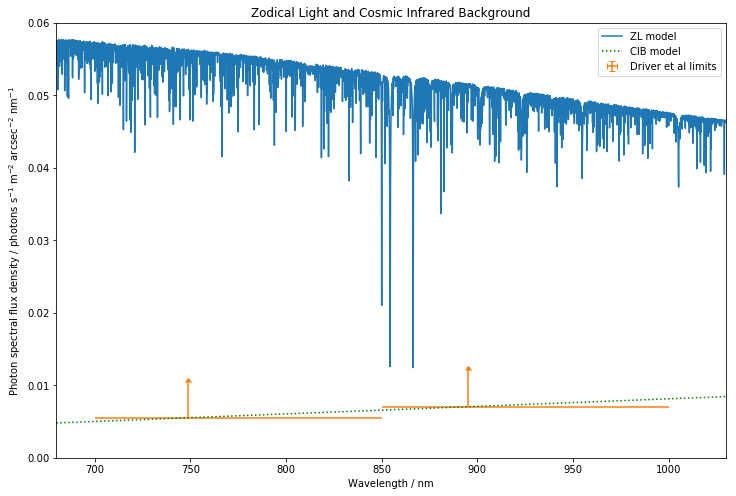

In [34]:
plt.plot(ase_2017.sky.waves.to(u.nm), 
         ase_2017.sky.photon_sfd.to(u.photon * u.s**-1 * u.m**-2 * u.arcsecond**-2 * u.nm**-1), label='ZL model')
plt.errorbar(cib_waves.value, cib_limit_photon.value, xerr=((49,45), (101, 105)), 
             yerr=0.005, lolims=True, linestyle='none', label='Driver et al limits')
plt.plot(ase_2017.wavelengths, cib_model(ase_2017.wavelengths), 'g:', label='CIB model')
plt.legend()
plt.xlim(680, 1030)
plt.ylim(0,0.06)
plt.title('Zodical Light and Cosmic Infrared Background')
plt.xlabel('Wavelength / nm')
plt.ylabel('Photon spectral flux density / photons s$^{-1}$ m$^{-2}$ arcsec$^{-2}$ nm$^{-1}$')
plt.gcf().set_size_inches(12,8)

Now calculate expected signal and noise for ZL and CIB. We consider 1 months of observing on a given target field, with a duty cycle of 40%, 40 minute sub-exposures and exposure time equally divided between the 6 (or 4) filters.

### Virtual narrowband filter set

Expected values for combined data.

In [100]:
filter_fraction = 1 / 6 # 6 filters
t_exp = 1 * 30 * u.day * duty_cycle * filter_fraction
t_sub = 40 * u.minute

virtual_nb_data = {}

for filter_name in ase_2016.filter_names:
    cib_signal, noise = ase_2016.extended_source_signal_noise(surface_brightness=cib_model,
                                                              filter_name=filter_name,
                                                              total_exp_time=t_exp,
                                                              sub_exp_time=t_sub,
                                                              calc_type='per arcsecond squared')
    zl_signal, noise_again = ase_2016.extended_source_signal_noise(surface_brightness=None,
                                                                   filter_name=filter_name,
                                                                   total_exp_time=t_exp,
                                                                   sub_exp_time=t_sub,
                                                                   calc_type='per arcsecond squared')
    virtual_nb_data[filter_name] = u.Quantity([cib_signal, zl_signal, noise])

virtual_nb_data

{'ase_i1': <Quantity [  552.90125893, 5251.6339676 ,   81.8503272 ] electron / arcsec2>,
 'ase_i2': <Quantity [  563.10506722, 5323.73777411,   82.35158576] electron / arcsec2>,
 'ase_i3': <Quantity [  574.34306465, 5412.40922442,   82.955971  ] electron / arcsec2>,
 'ase_z1': <Quantity [  215.90605097, 1492.3829661 ,   51.02185662] electron / arcsec2>,
 'ase_z2': <Quantity [  205.35590452, 1417.10118164,   50.17367759] electron / arcsec2>,
 'ase_z3': <Quantity [  195.33623237, 1339.48754949,   49.29264264] electron / arcsec2>}

To estimate the signal to noise in the derived parameters we will fit a simple model to the simulated photometric data in order to recover the basic parameters, ZL flux scaling, CIB flux scaling and CIB spectral slope.  We will assume binning to arcminute scales.

In [121]:
def virtual_nb_model(ZL_scaling, CIB_scaling, CIB_slope, binning_scale=1 * u.arcminute, add_noise=False):
    data = {}
    
    for filter_name in ase_2016.filter_names:
        cib_signal, noise = ase_2016.extended_source_signal_noise(surface_brightness=lambda w: cib_model(w,
                                                                                                         CIB_scaling * cib_850,
                                                                                                         CIB_slope * cib_gradient),
                                                                  filter_name=filter_name,
                                                                  total_exp_time=t_exp,
                                                                  sub_exp_time=t_sub,
                                                                  calc_type='per arcsecond squared')
        
        zl_signal, noise_again = ase_2016.extended_source_signal_noise(surface_brightness=None,
                                                                       filter_name=filter_name,
                                                                       total_exp_time=t_exp,
                                                                       sub_exp_time=t_sub,
                                                                       calc_type='per arcsecond squared')
        
        cib_signal = (cib_signal * binning_scale**2).to(u.electron)
        zl_signal = (zl_signal * binning_scale**2).to(u.electron)
        binning_scale = binning_scale.to(u.arcsecond)
        noise = (noise * binning_scale.value * binning_scale.unit**2).to(u.electron)
        noise_again = (noise_again * binning_scale.value * binning_scale.unit**2).to(u.electron)
        
        if add_noise:
            data[filter_name] = cib_signal + ZL_scaling * zl_signal + np.random.normal(scale=noise.value) * noise.unit
        else:
            data[filter_name] = (cib_signal + ZL_scaling * zl_signal, 
                                 ((ZL_scaling - 1) * noise_again**2 + noise**2)**0.5)
        
    return data

In [122]:
virtual_nb_model(1.0, 1.0, 1.0)['ase_i1']

(<Quantity 20896326.815514065 electron>, <Quantity 4911.019632034032 electron>)

In [133]:
def residual(params):
    model_data = virtual_nb_model(params[0], 
                                  params[1],
                                  params[2],
                                  binning_scale)
    residuals = []
    
    for filter_name in ase_2016.filter_names:
        datum = data[filter_name]
        residuals.append((datum - model_data[filter_name][0]) / model_data[filter_name][1])
        
    return residuals

For an estimate of signal to noise will simply use a brute force Monte Carlo method, create a number of sets of simulated data with noise added to the photometric values and look at the distribution of fitting parameter values.

In [142]:
parameters = []
binning_scale = 30 * u.arcminute
for i in range(30):
    data = virtual_nb_model(1.0, 1.0, 1.0, binning_scale, add_noise=True)
    fit = least_squares(residual, (1.0, 1.0, 1.0), bounds=((0.9, 0.0, -5.0), (1.1, 2.0, 5.0)))
    parameters.append(fit.x)

parameters = np.array(parameters)

In [143]:
np.array(parameters)

array([[ 0.99649221,  1.02743246,  0.98851475],
       [ 1.00081648,  0.993657  ,  1.0030416 ],
       [ 0.99890578,  1.00859154,  0.99647296],
       [ 0.9973799 ,  1.02048031,  0.99153437],
       [ 1.00421799,  0.96703045,  1.0137973 ],
       [ 0.99915516,  1.00664562,  0.9972871 ],
       [ 1.00286395,  0.97759016,  1.009397  ],
       [ 1.00475473,  0.96286565,  1.01579378],
       [ 0.99591643,  1.03188123,  0.9863391 ],
       [ 0.99589193,  1.03209398,  0.9862553 ],
       [ 0.99681589,  1.02490658,  0.98971027],
       [ 0.99789574,  1.01648721,  0.99332293],
       [ 1.00101484,  0.99208188,  1.00342527],
       [ 0.99536669,  1.03619757,  0.98484935],
       [ 1.00002914,  0.99974329,  1.00000585],
       [ 0.99948376,  1.00401283,  0.99820776],
       [ 1.00303943,  0.97628165,  1.01017346],
       [ 0.99807523,  1.01505298,  0.99400017],
       [ 1.00053102,  0.99588278,  1.00198259],
       [ 1.00321419,  0.97486235,  1.01045903],
       [ 0.99903576,  1.00753795,  0.996

In [144]:
parameters.mean(axis=0)

array([ 0.99966278,  1.00264401,  0.99897955])

In [145]:
parameters.std(axis=0, ddof=1)

array([ 0.00250314,  0.01956108,  0.00823378])

###  Standard Narrowband filter set

In [128]:
filter_fraction = 1 / 4 # 4 filters
t_exp = 3 * 30 * u.day * duty_cycle * filter_fraction
t_sub = 40 * u.minute
n_sub = (t_exp / t_sub).to(u.dimensionless_unscaled) # Number of sub-exposures per filter

standard_data = {}

for filter_name in ase_2017.filter_names:
    cib_signal, noise = ase_2017.extended_source_signal_noise(surface_brightness=cib_model,
                                                              filter_name=filter_name,
                                                              total_exp_time=t_exp,
                                                              sub_exp_time=t_sub,
                                                              calc_type='per pixel')
    zl_signal, noise_again = ase_2017.extended_source_signal_noise(surface_brightness=None,
                                                                   filter_name=filter_name,
                                                                   total_exp_time=t_exp,
                                                                   sub_exp_time=t_sub,
                                                                   calc_type='per pixel')
    standard_data[filter_name] = (cib_signal, zl_signal, noise)

standard_data

{'ase_i1': (<Quantity 22419.002542051174 electron / pix>,
  <Quantity 212942.8959821967 electron / pix>,
  <Quantity 521.2004398734213 electron / pix>),
 'ase_nb855': (<Quantity 297.5830868485739 electron / pix>,
  <Quantity 2045.277078827715 electron / pix>,
  <Quantity 196.5473484066277 electron / pix>),
 'ase_nb858': (<Quantity 288.88685615696016 electron / pix>,
  <Quantity 2230.265101195096 electron / pix>,
  <Quantity 196.9953094805865 electron / pix>),
 'ase_z3': (<Quantity 7920.480229118709 electron / pix>,
  <Quantity 54313.449810131555 electron / pix>,
  <Quantity 313.8820320426932 electron / pix>)}

In [92]:
def standard_nb_model(ZL_scaling, CIB_scaling, CIB_slope, add_noise=False):
    data = {}
    
    for filter_name in ase_2017.filter_names:
        cib_signal, noise = ase_2017.extended_source_signal_noise(surface_brightness=lambda w: cib_model(w,
                                                                                                         CIB_scaling * cib_850,
                                                                                                         CIB_slope * cib_gradient),
                                                                  filter_name=filter_name,
                                                                  total_exp_time=t_exp,
                                                                  sub_exp_time=t_sub,
                                                                  calc_type='per arcsecond squared')
        
        zl_signal, noise_again = ase_2017.extended_source_signal_noise(surface_brightness=None,
                                                                       filter_name=filter_name,
                                                                       total_exp_time=t_exp,
                                                                       sub_exp_time=t_sub,
                                                                       calc_type='per arcsecond squared')
        
        cib_signal = cib_signal.to(u.electron/u.arcminute**2)
        zl_signal = zl_signal.to(u.electron/u.arcminute**2)
        noise = noise.to(u.electron/u.arcminute**2) / 60
        noise_again = noise_again.to(u.electron/u.arcminute**2) / 60
        
        if add_noise:
            data[filter_name] = cib_signal + ZL_scaling * zl_signal + np.random.normal(scale=noise.value) * noise.unit
        else:
            data[filter_name] = (cib_signal + ZL_scaling * zl_signal, 
                                 ((ZL_scaling - 1) * noise_again**2 + noise**2)**0.5)
        
    return data

In [93]:
parameters = []
for i in range(20):
    data = virtual_nb_model(1.0, 1.0, 1.0, add_noise=True)
    fit = least_squares(residual, (1.0, 1.0, 1.0), bounds=((0.9, 0.0, -5.0), (1.1, 2.0, 5.0)), verbose=1)
    parameters.append(fit.x)
    
parameters = np.array(parameters)

`xtol` termination condition is satisfied.
Function evaluations 10, initial cost 2.7151e+00, final cost 2.1736e+00, first-order optimality 2.65e-04.
`ftol` termination condition is satisfied.
Function evaluations 6, initial cost 1.2748e+00, final cost 6.9188e-01, first-order optimality 1.40e-05.
`ftol` termination condition is satisfied.
Function evaluations 9, initial cost 1.7442e+00, final cost 5.9461e-01, first-order optimality 3.51e-04.
`xtol` termination condition is satisfied.
Function evaluations 13, initial cost 1.9537e+00, final cost 3.9027e-01, first-order optimality 5.01e-04.
`xtol` termination condition is satisfied.
Function evaluations 11, initial cost 4.7518e+00, final cost 9.8252e-01, first-order optimality 4.44e-04.
Both `ftol` and `xtol` termination conditions are satisfied.
Function evaluations 11, initial cost 4.8297e+00, final cost 4.2326e+00, first-order optimality 7.08e-04.
`ftol` termination condition is satisfied.
Function evaluations 12, initial cost 1.1699e+0

In [94]:
parameters

array([[ 0.95603797,  1.34368251,  0.85313486],
       [ 1.00169596,  0.98632103,  1.00698201],
       [ 0.96153342,  1.30063452,  0.86804015],
       [ 0.91550981,  1.65950432,  0.71935352],
       [ 1.04145389,  0.67570835,  1.14522958],
       [ 0.97883231,  1.16470738,  0.92521576],
       [ 1.03125242,  0.75666656,  1.10715227],
       [ 1.02482983,  0.80440937,  1.07475235],
       [ 0.99718325,  1.02135579,  0.99445403],
       [ 1.04637355,  0.63901256,  1.16208033],
       [ 1.02933722,  0.77109717,  1.09883321],
       [ 1.1       ,  0.21851418,  1.3320923 ],
       [ 1.1       ,  0.21823609,  1.31472896],
       [ 1.07452476,  0.41795863,  1.24752386],
       [ 1.03168665,  0.75117376,  1.09624264],
       [ 0.98326074,  1.13023683,  0.93564856],
       [ 0.9       ,  1.78306574,  0.67826774],
       [ 0.94912859,  1.39603324,  0.82694248],
       [ 0.91860138,  1.63646367,  0.73682961],
       [ 1.00252747,  0.9795439 ,  1.00382546]])

In [95]:
parameters.mean(axis=0)

array([ 1.00218846,  0.98271628,  1.00636648])

In [96]:
parameters.std(axis=0, ddof=1)

array([ 0.05771758,  0.45105982,  0.18967441])